# Assignement 1 Notebook : ML for Time Series
### Authors : Simon Queric and Vincent Herfeld

# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from scipy.signal import correlate

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

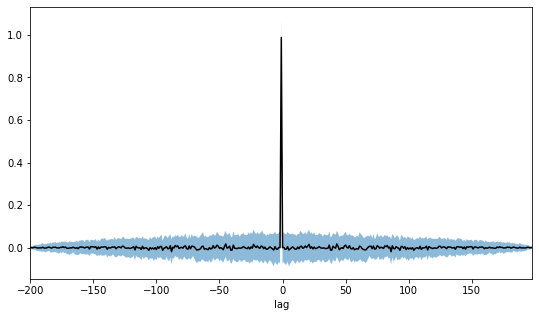

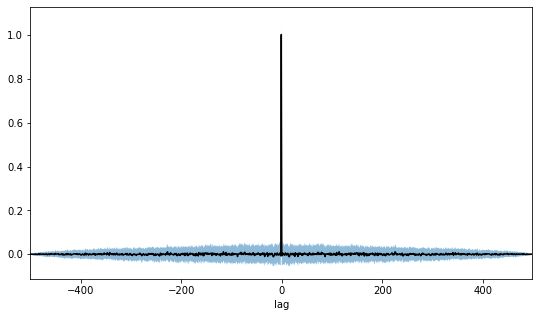

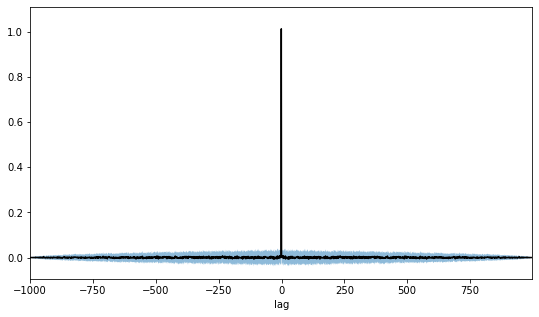

In [3]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
freqs = np.linspace(0, 0.5, 200)

ns = 100 #number of samples
fs = 1 #Hz
for N in np.array([200, 500, 1000]): #length of the sequences
    X = np.random.normal(size=(ns,N))
    autocov = np.array([np.sum(X[i]*X[i])/N for i in range(ns)]).reshape(ns,-1)
    autocov = np.concatenate((autocov,np.array([[np.sum(X[k,:-tau] * X[k, tau:]) / N for tau in range(1, N)] for k in range(ns)]).reshape(ns,-1)),axis=1)
    autocov = np.concatenate((np.flip(autocov), autocov[:,1:]),axis=1)

    fig, ax = fig_ax(figsize=(9, 5))

    avg = autocov.mean(axis=0)
    std = autocov.std(axis=0)
    tau = np.arange(-N,N-1)
    ax.plot(tau, avg, 'k-')
    ax.fill_between(tau, avg-std, avg+std, alpha=0.5)
    plt.xlabel("lag")
    plt.savefig('autocov N={}.png'.format(N))



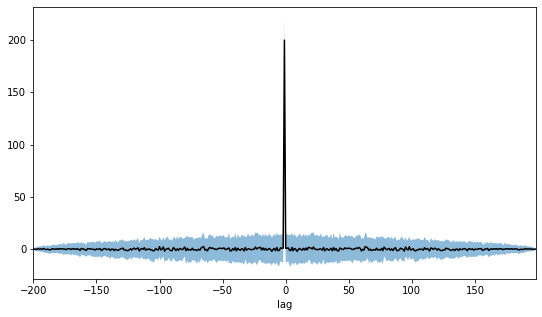

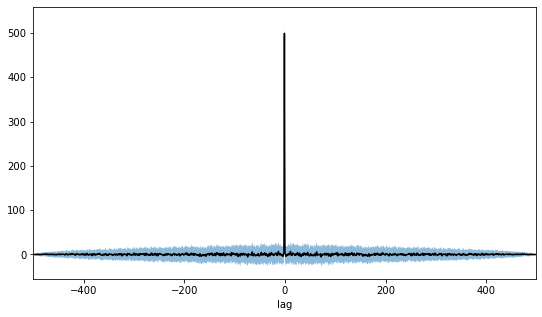

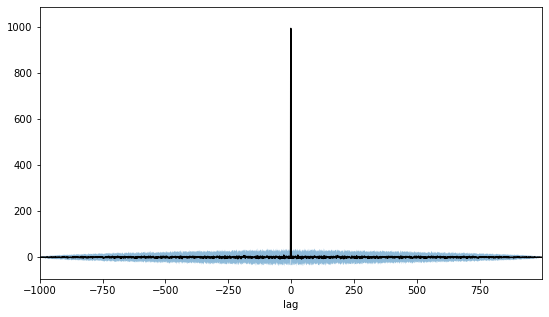

In [4]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
freqs = np.linspace(0, 0.5, 200)

ns = 100 #number of samples
fs = 1 #Hz

for N in np.array([200, 500, 1000]): #length of the sequences
    X = np.random.normal(size=(ns, N))
    autocov = np.empty((ns, 2*N-1))
    for i in range(ns) :
        autocov[i] = correlate(X[i], X[i])


    fig, ax = fig_ax(figsize=(9, 5))

    avg = autocov.mean(axis=0)
    std = autocov.std(axis=0)
    tau = np.arange(-N,N-1)
    ax.plot(tau, avg, 'k-')
    ax.fill_between(tau, avg-std, avg+std, alpha=0.5)
    plt.xlabel("lag")
    plt.savefig('autocov N={}.png'.format(N))

In [5]:
def periodogram(signal):
  pdgm = np.abs(np.fft.fft(signal, axis=0))**2 / len(signal)
  return pdgm

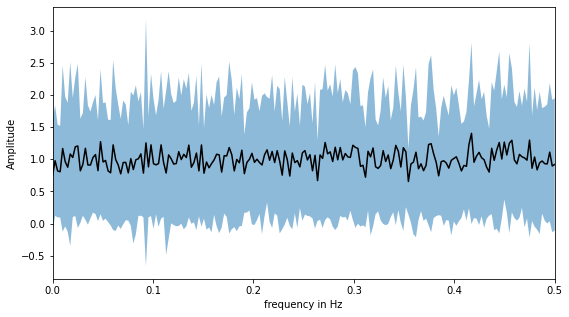

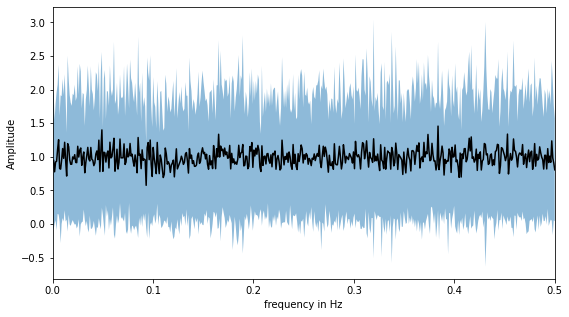

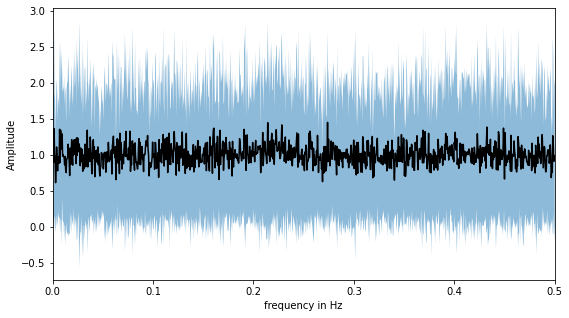

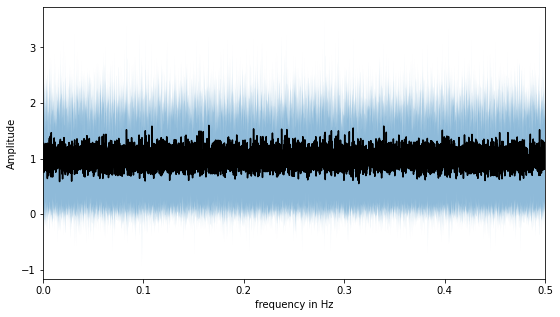

In [6]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines

ns = 100
fs = 1 #Hz
for N in np.array([200, 500, 1000, 10000]):
    freqs = np.linspace(0, fs * 0.5, N)
    X = np.random.normal(size=(ns, N))
    pdgm = periodogram(X)

    fig, ax = fig_ax(figsize=(9, 5))

    avg = pdgm.mean(axis=0)
    std = pdgm.std(axis=0)
    ax.plot(freqs, avg, 'k-')
    ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)
    plt.xlabel("frequency in Hz")
    plt.ylabel("Amplitude")
    plt.savefig('periodo N={}.png'.format(N))

We can display the histogram of the periodogram for frequency $kf_s/N$ with $k=4$. We get a nice exponential distribution.

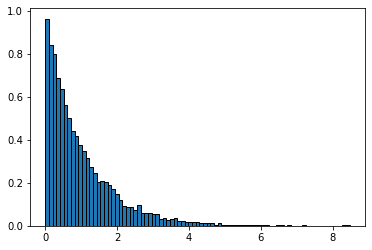

In [31]:
plt.hist(pdgm[-1], density=True, bins='auto', edgecolor='k')
plt.show()

## Question 9

In [21]:
def Bartlett(signal, num_sub_samples):
  N = len(signal)
  periodograms = []
  M = int(N / num_sub_samples)
  for k in range(num_sub_samples):
    periodograms.append(periodogram(signal[k * M :min((k + 1) * M, N)]))
  pdgm = np.sum(periodograms, axis =0) / num_sub_samples
  return pdgm

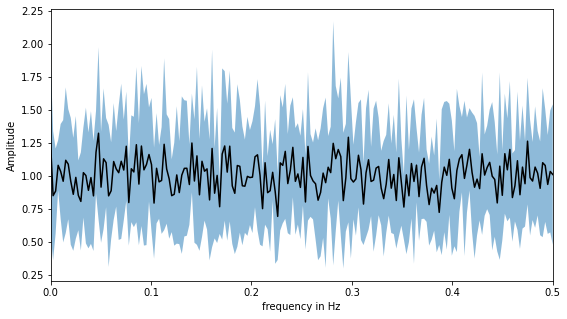

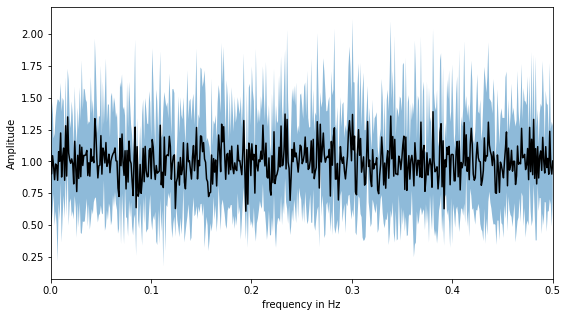

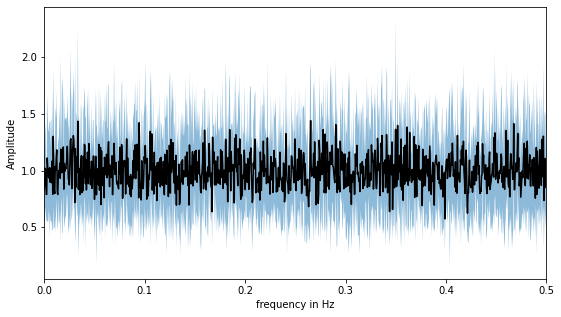

In [8]:
ns = 100
fs = 1 #Hz
K = 5
for N in np.array([200, 500, 1000]):
    freqs = np.linspace(0, fs * 0.5, N)
    X = np.random.normal(size=(ns, N))

    pdgm = Bartlett(X, K)

    fig, ax = fig_ax(figsize=(9, 5))

    avg = pdgm.mean(axis=0)
    std = pdgm.std(axis=0)
    ax.plot(freqs, avg, 'k-')
    ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)
    plt.xlabel("frequency in Hz")
    plt.ylabel("Amplitude")
    plt.savefig('bartlett N={}.png'.format(N))


# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [9]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)


## Question 10

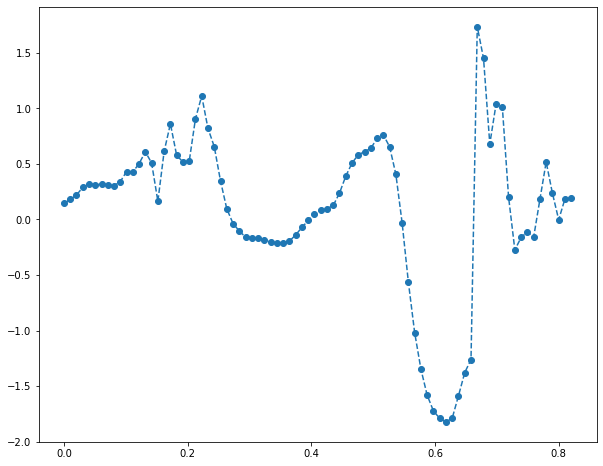

In [10]:
fs = 100#Hz
fig = plt.figure(figsize=(10, 8))
plt.plot(np.linspace(0, len(X_train[10])/fs, len(X_train[10])),X_train[10], marker="o", linestyle="dashed")

In [11]:
from dtw import dtw
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



We first calculate all the distances between the signals using DTW, this is because the signals are not all of same length and padding the signals modifies the DTW.

In [12]:
X_train_distances = np.empty((len(X_train), len(X_train)))

for i,x in enumerate(X_train):
  for j,y in enumerate(X_train):
    X_train_distances[i][j] = dtw(x, y, distance_only=True).distance

X_test_train_distances = np.empty((len(X_test), len(X_train)))

for i,x in enumerate(X_test):
  for j,y in enumerate(X_train):
    X_test_train_distances[i][j] = dtw(x, y, distance_only=True).distance

Then we apply the KNN algorithm with additional cross-validation to find the best number of neighbors to use.

In [20]:
kNN = KNeighborsClassifier(weights="distance", metric='precomputed')
parameters = {"n_neighbors" : range(1, 20)}
kfold = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=kNN, param_grid=parameters, scoring = "f1", cv=kfold)
clf.fit(X_train_distances, y_train)
clf.best_params_

{'n_neighbors': 1}

In [21]:
print("Optimal value of n_neighbors : {}".format(clf.best_params_["n_neighbors"]))

Optimal value of n_neighbors : 1


Unfortunately it seems that the optimal value of n_neighbors fluctuates between runs.

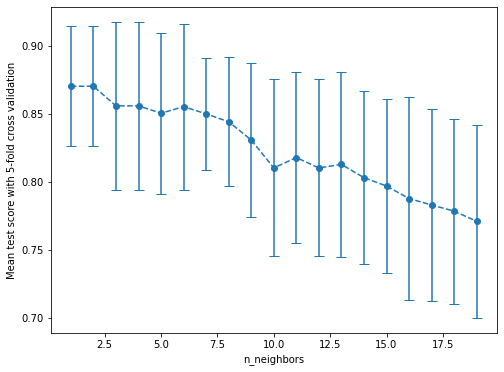

In [22]:
fig = plt.figure(figsize=(8, 6))
plt.errorbar(range(1, 20), clf.cv_results_["mean_test_score"], yerr=clf.cv_results_["std_test_score"], fmt='o', ls='--', capsize = 5)
plt.xlabel("n_neighbors")
plt.ylabel("Mean test score with 5-fold cross validation")
plt.show()

We build this time using the decision made from the cross-validation step

In [23]:
k = clf.best_params_["n_neighbors"]
kNC = KNeighborsClassifier(n_neighbors=k, weights="distance", metric='precomputed')

In [24]:
kNC.fit(X_train_distances, y_train)
y_pred_test = kNC.predict(X_test_train_distances)

print("F1 score : {}".format(sklearn.metrics.f1_score(y_test, y_pred_test)))
print("Accuracy : {}".format(np.sum((y_pred_test == y_test))/len(y_pred_test)))

F1 score : 0.5132743362831859
Accuracy : 0.375


The F1 score is not too bad (but doesn't seem very high) for the train set but it seems to drop low on the test set. We believe that this is maybe due to the fact that we are working only with the data revolving around vertical acceleration of the left foot. Maybe this information is too restrictive to classify well using only the KNN algorithm.

## Question 11

We extract a badly classified healthy step and a badly classified unhealthy step

In [25]:
check = y_pred_test != y_test

for i in range(len(check)):
    if check[i] and y_test[i] == 0:
        badly_classified_healthy = X_test[i]
        break

for i in range(len(check)):
    if check[i] and y_test[i] == 1:
        badly_classified_unhealthy = X_test[i]
        break

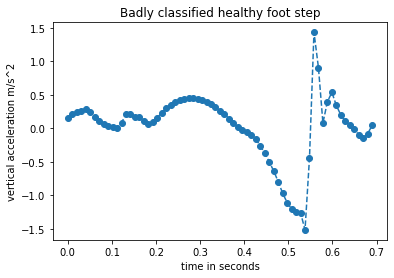

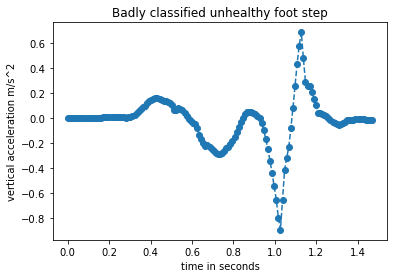

In [26]:

plt.plot(np.linspace(0,len(badly_classified_healthy)/fs, len(badly_classified_healthy)), badly_classified_healthy, marker="o", linestyle="dashed")
plt.title("Badly classified healthy foot step")
plt.xlabel('time in seconds')
plt.ylabel('vertical acceleration m/s^2')
plt.savefig('BCHealthy.png')
plt.show()

plt.plot(np.linspace(0,len(badly_classified_unhealthy)/fs, len(badly_classified_unhealthy)), badly_classified_unhealthy, marker="o", linestyle="dashed")
plt.title("Badly classified unhealthy foot step")
plt.xlabel('time in seconds')
plt.ylabel('vertical acceleration m/s^2')
plt.savefig('BCUnHealthy.png')
plt.show()
         